<a href="https://colab.research.google.com/github/saspav/python_for_pro/blob/main/HW_ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Домашняя работа**</font>  
<font color='#11a642' size='6'>**Тема: Машинное обучение. Алгоритм Дерево решений**</font>  
<font size='5'>**Задание:**</font>  

Домашняя работа основана на данных конкурса https://www.kaggle.com/competitions/playground-series-s5e5  

**Что нужно сделать:**

1. Загрузить данные c конкурса  https://www.kaggle.com/competitions/playground-series-s5e5
2. Проведисти разведочный анализ данных (EDA)  
3. Построить деревья решений


**Форма загрузки на платформу:** строго файл ipynb. Перед загрузкой еще раз запустите ноутбук, убедившись, что все работает корректно без ошибок






# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import random

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (  # Метрики оценки качества модели
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer,
)
from collections import Counter

pd.set_option('display.precision', 5)  # Отображение ДФ с 5-ю знаками после запятой

In [2]:
# Зафиксируем сиды

SEED = 127
np.random.seed(SEED)
random.seed(SEED)

# <font color='#11a642' size='6'> **Функции**

In [3]:
def memory_compression(df, use_category=True, use_float=True, exclude_columns=None):
    """
    Изменение типов данных для экономии памяти
    :param df: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :param use_float: преобразовывать float в пониженную размерность
    :param exclude_columns: список колонок, которые нужно исключить из обработки
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    for col in df.columns:

        if exclude_columns and col in exclude_columns:
            continue

        if str(df[col].dtype)[:4] in 'datetime':
            continue

        elif str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif (col_min > np.finfo(np.float32).min
                      and col_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        elif use_category and str(df[col].dtype) == 'object':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def rmsle(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: RMSLE
    """
    y_true = np.array(y_true)
    y_pred = np.maximum(0, np.array(y_pred))
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))


def get_metrics(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: метрики
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmsle_ = rmsle(y_true, y_pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'rmsle': rmsle_}


def calculate_outliers(dfs, q_range=1.5):
    """
    Функция для расчета выбросов через IQR
    :param dfs: датафрейм
    :param q_range: диапазон IQR
    :return: маска с выбросами
    """
    Q1 = dfs.quantile(0.25)
    Q3 = dfs.quantile(0.75)
    IQR = (Q3 - Q1) * q_range
    return (dfs < (Q1 - IQR)) | (dfs > (Q3 + IQR))


def train_valid_model(model_num, model_params, df_train, df_valid,
                      model_cols, target_col, target_log=False):
    """
    Процедура обучения и валидации модели
    :param model_num: Порядковый номер модели
    :param model_params: Параметры модели
    :param df_train: обучающий ДФ
    :param df_valid: валидационный ДФ
    :param model_cols: список признаков
    :param target_col: целевая переменная
    :param target_log: логарифмировать целевой признак
    :return: обученная модель, ДФ с метриками, Серия с важностью признаков
    """
    X_train, y_train = df_train[model_cols], df_train[target_col]
    X_valid, y_valid = df_valid[model_cols], df_valid[target_col]

    model = DecisionTreeRegressor(**model_params,
                                  random_state=SEED,
                                  splitter='best',  # Фиксируем стратегию разделения
                                 )

    if target_log:
        # Логарифмируем целевой признак
        model.fit(X_train, np.log1p(y_train))
        # Преобразуем в нормальный масштаб предсказания
        y_pred_train = np.expm1(model.predict(X_train))
        y_pred_valid = np.expm1(model.predict(X_valid))
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)

    metrics_train = get_metrics(y_train, y_pred_train)
    metrics_valid = get_metrics(y_valid, y_pred_valid)

    metric_t = f'Train{model_num}'
    metric_v = f'Valid{model_num}'

    # Создаем DataFrame
    metrics = pd.DataFrame({'Metric': list(metrics_train.keys()),
                            metric_t: list(metrics_train.values()),
                            metric_v: list(metrics_valid.values())})

    # Добавляем разницу между train и valid (в %)
    metrics[f'Diff{model_num},%'] = ((metrics[metric_v] - metrics[metric_t])
                                     / metrics[metric_t] * 100).round(2)
    return model, metrics, model.feature_importances_


def find_best_model(metrics_df):
    """
    Процедура поиска лучшей модели по метрикам
    :param metrics_df: ДФ с метриками
    :return: None
    """
    models = []
    for idx, row in metrics_df.iterrows():
        metric_name = row['Metric']

        # Отбираем только численные значения из колонок Valid*
        valid_cols = [col for col in metrics_df.columns if col.startswith('Valid')]
        valid_values = row[valid_cols]

        if metric_name.strip().lower() == 'r2':
            best_col = valid_values.idxmax()
            best_val = valid_values.max()
        else:
            best_col = valid_values.idxmin()
            best_val = valid_values.min()

        models.append(best_col)

        print(f"Метрика: {metric_name:<5} --> лучшая модель: {best_col} ({best_val:.4f})")

    result = Counter(models).most_common()[0]
    print('\nЛучшая модель: {} на {} метриках из {}'.format(*result, len(models)))


def show_tree(model_num, model, model_cols,  max_depth=3):
    """
    Процедура отрисовки дерева решений
    :param model_num: Номер модели
    :param model: обученная модель
    :param model_cols: признаки, поданные в модель
    :param max_depth: глубина отрисовки дерева
    :return: None
    """
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=model_cols,
        filled=True,
        rounded=True,
        max_depth=max_depth,  # Показываем только max_depth уровня
        fontsize=12
    )
    plt.title(f"Дерево решений для Модели {model_num}", fontsize=22)
    plt.show()

# <font color='#11a642' size='6'> **Загрузка данных**

In [4]:
try:
    df = pd.read_csv('https://drive.google.com/uc?id=1_GGhdAONTOpW3HQcM665rk3CEl7A6r4C')
except:
    df = pd.read_csv('train_сalories.csv')

In [5]:
# на этих данных дальше необходимо разработать модель
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [6]:
# Колонка "id" не несет смысла - это индекс
df.set_index("id", inplace=True)

## <font color='#11a642' size='5'> Роли для независимых признаков

In [7]:
target = 'Calories'

# <font color='#11a642' size='6'> **Разведочный анализ данных**

<font color='#11a642' size='5'>
Оцените размер вашего датасета  

1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [8]:
# Сколько ГБ ваш датасет
df.memory_usage(deep=True).sum() / 1024 ** 3

np.float64(0.08801132626831532)

In [9]:
# Сколько строк и столбцов
df.shape

(750000, 8)

<font color='#11a642' size='5'>
Рекомендуется:

- посмотреть на `df.info()`, `df.describe()`
- визуализировать распределения целевой переменной и признаков (гистограммы, boxplot)
- посмотреть на корреляции (`df.corr()`)
- проверить пропуски

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


- В датасете 8 признаков: 1 текстовый, 1 - int, остальные - float
- 750000 строк
- пропусков нет
- в памяти 51.5+ MB

In [11]:
# Выбираем числовые колонки
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Считаем требуемые статистики
df[num_cols].agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
Age,20.0,79.0,41.42040,40.0
Height,126.0,222.0,174.69769,174.0
Weight,36.0,132.0,75.14567,74.0
Duration,1.0,30.0,15.42101,15.0
Heart_Rate,67.0,128.0,95.48399,95.0
Body_Temp,37.1,41.5,40.03625,40.3
Calories,1.0,314.0,88.28278,77.0


In [12]:
# Кол-во пропущенных значений по каждому признаку
print("Пропущенные значения по столбцам:")
print(df.isnull().sum())

# Кол-во дубликатов
print("\nКоличество дубликатов в датафрейме:")
print(df.duplicated().sum())

Пропущенные значения по столбцам:
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Количество дубликатов в датафрейме:
2841


С виду хорошие данные: пропусков нет, явных выбросов нет, но есть дубликаты - нужно от них избавиться.

In [13]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


In [14]:
# Выбираем категориальные колонки (включая строки и категории)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

df[cat_cols].value_counts(normalize=True)

,proportion
Sex,
female,0.50095
male,0.49905


Распределение по полу почти поровну.

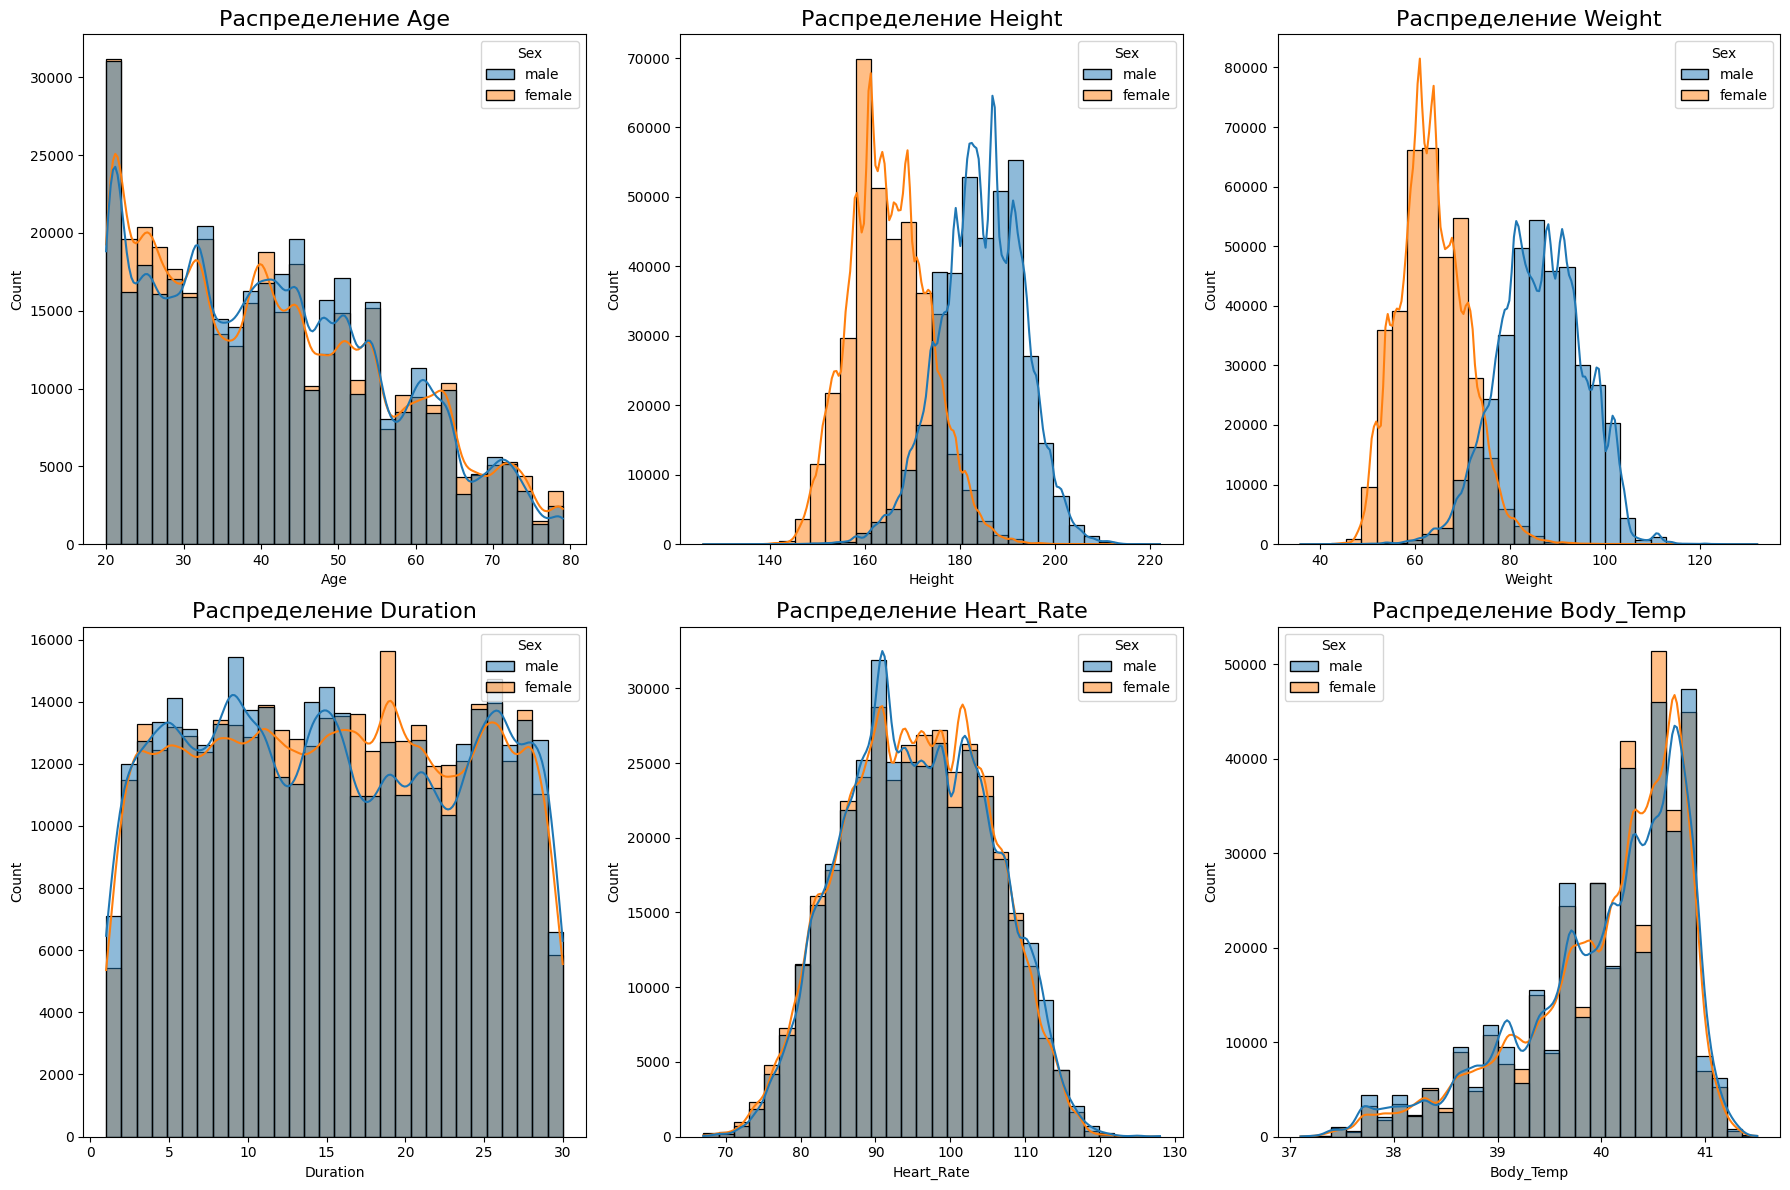

In [15]:
# строим распределение каждого из признаков
numeric_cols = num_cols.copy()
numeric_cols.remove(target)

# Создаем grid графиков
n_cols = 3  # Количество столбцов в grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, hue='Sex', bins=30, kde=True, alpha=0.5)
    plt.title(f'Распределение {col}', fontsize=16)
    plt.grid(False)

plt.tight_layout()
plt.show()

Выводы по признакам с учётом **разделения по полу**:

---

### 🔹 **Age (Возраст)**

* **Явно скошенное распределение в сторону молодого возраста**.
* Всплеск на 20 лет — возможно, большое число молодых пользователей, или это нижняя граница по возрасту.
* Постепенное убывание с пиками на круглых датах (30, 40, 50…) — **возможны округления или предпочтения при вводе**.
* Мужчины и женщины распределены схоже.

📌 *Комментарий*: можно рассматривать категориализацию по возрастным группам. Проверить, нет ли "артефактов" (например, 20 лет — подозрительно много).

---

### 🔹 **Height (Рост)**

* Мужчины (синие): максимум около 178–180 см. Широкое распределение, от 160 до 200+.
* Женщины (оранжевые): максимум около 160–165 см, левее и компактнее.

📌 *Комментарий*: чёткое разделение по полу, как ожидается. Распределения адекватны, но **значения ниже 140 см и выше 210 см** — стоит проверить как возможные выбросы.

---

### 🔹 **Weight (Вес)**

* Аналогичная картина: мужчины тяжелее, женщины легче.
* Центры распределений: мужчины — около 80 кг, женщины — 60 кг.
* Некоторая асимметрия: скошенность вправо (особенно у мужчин).

📌 *Комментарий*: значения ниже 45 кг и выше 120 кг — стоит рассматривать как потенциальные выбросы или крайние значения. Распределение выглядит реалистично.

---

### 🔹 **Duration (Длительность)**

* Почти **равномерное распределение** от 1 до 30.
* Пол не влияет — мужские и женские графики совпадают.

📌 *Комментарий*: скорее всего, это **искусственно ограниченный интервал** (возможно, длительность тренировок или сеансов). Можно оставить как есть, или бининговатить.

---

### 🔹 **Heart\_Rate (Пульс)**

* Пульс распределён **нормально**, с пиком около 90–100 уд/мин.
* Мужчины и женщины снова похожи.
* Верхняя граница в 120–130 уд/мин — **в пределах нормы при нагрузке**.

📌 *Комментарий*: Можно создать бинарный признак «пульс выше 100» или «в пределах нормы» для медицины/фитнеса.

---

### 🔹 **Body\_Temp (Температура тела)**

* Распределение **от 37 до 41.5°C** — нехарактерно для нормальной температуры.
* Пик у 40–40.5°C — крайне высокая температура, **что-то не так**:

  * либо это **температура после физической активности** (если измерение по коже или под нагрузкой),
  * либо **единицы не Цельсий**, либо **ошибка сбора**.

📌 *Комментарий*: требует проверки. Средняя температура тела человека — **36.6–37.5°C**, и 40°C — это уже клиническое состояние.

---

### 🟩 Общие выводы:

✅ **Хорошо распределены**: `Age`, `Height`, `Weight`, `Heart_Rate`.

⚠️ **Проверить:**

* `Body_Temp` — вероятная ошибка шкалы или контекста измерения.

* Сделать **бокс-плоты** для `Weight`, `Height`, `Body_Temp`, `Calories` — выявить выбросы.

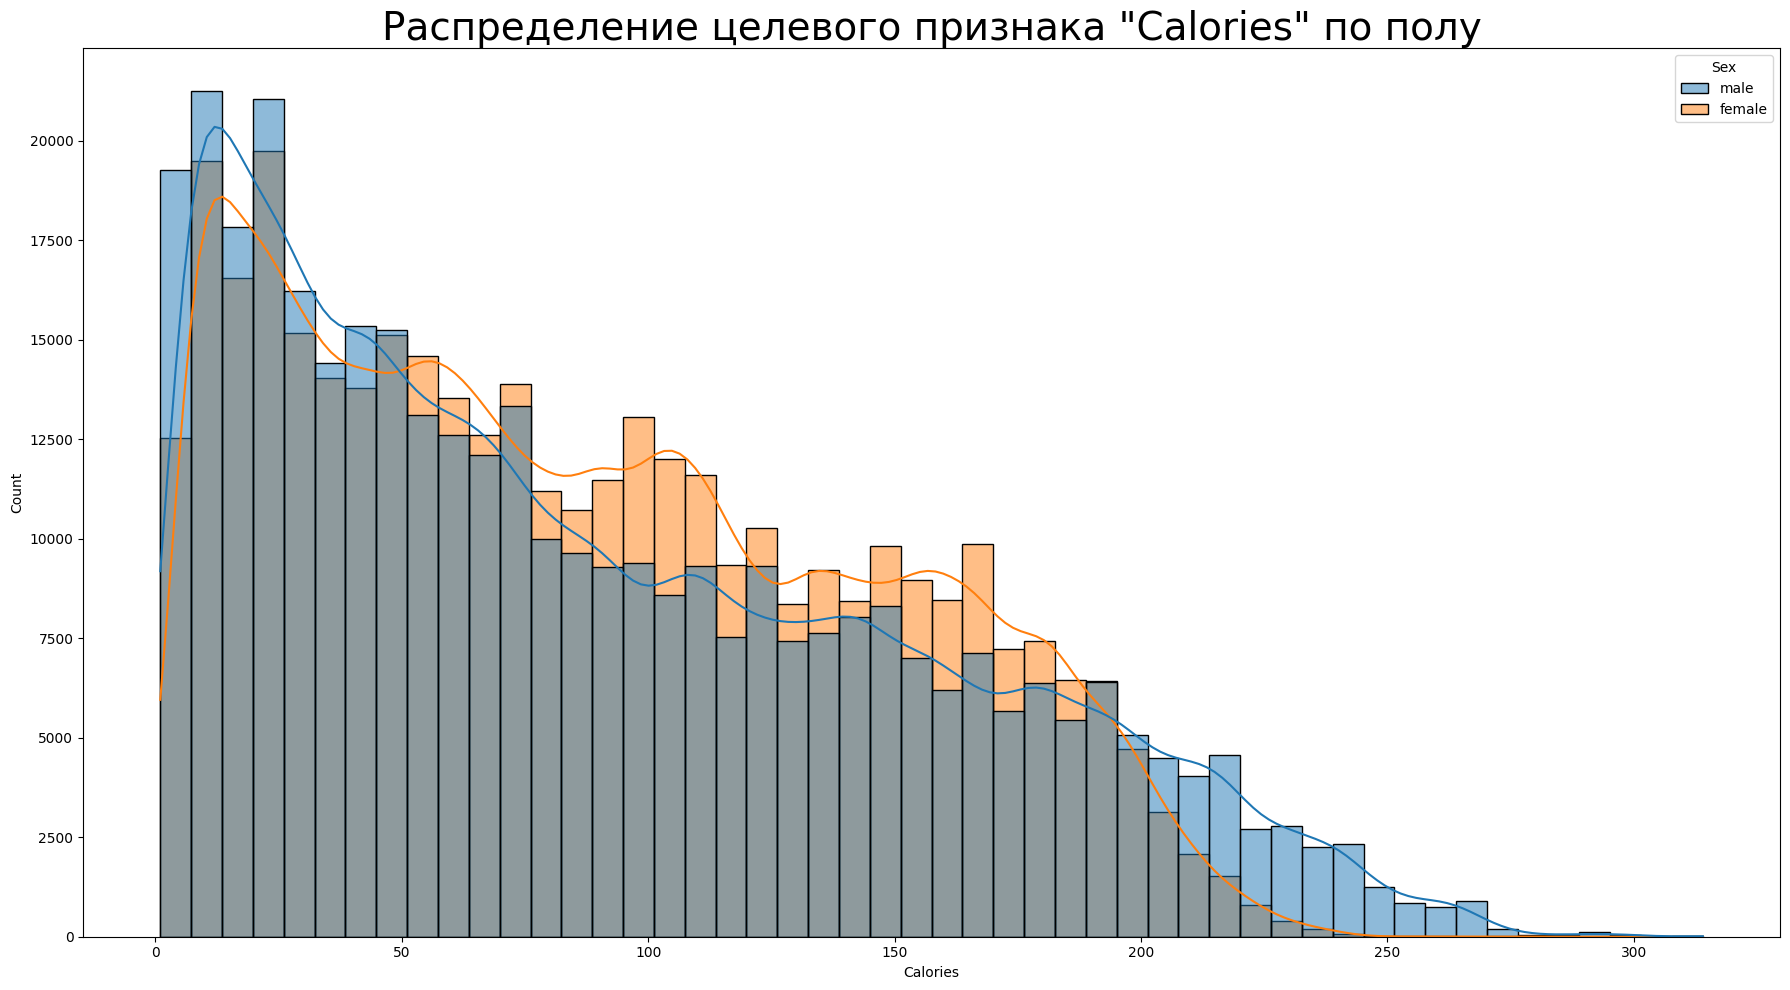

In [16]:
plt.figure(figsize=(18, 10))

sns.histplot(data=df, x=target, hue='Sex', bins=50, kde=True, alpha=0.5)
plt.title(f'Распределение целевого признака "{target}" по полу', fontsize=28)
plt.grid(False)

plt.tight_layout()
plt.show()

---

## 🔍 Распределение **Calories** (целевая переменная):

* **Распределение явно скошено влево** (асимметричное, с длинным "хвостом" вправо).
* Большинство значений лежит в пределах **0–150**, пик около **20–40 ккал**.
* Есть значения вплоть до **300+ ккал**, но они **редкие** — это **длинный хвост**, возможно, выбросы.
* Мужчины в среднем сжигают **больше калорий**, чем женщины:

  * У мужчин хвост правее, больше наблюдений с калориями >200.
  * У женщин максимум ближе к 80–120.

---

## 📌 Выводы:

1. **Распределение ненормальное**, высокая скошенность:

   * Это может затруднить регрессию если в качестве метрики взять MSE).
   * Рекомендуется **логарифмическое преобразование**: `log1p(Calories)` — устранит перекос.

2. **Выбросы**:

   * Значения выше **250–300 ккал** — **крайние и редкие**, стоит проверить:

     * корректны ли они?
     * не стоит ли обрезать/нормализовать?

3. **Различие по полу**:

   * Пол влияет на распределение — можно:

     * обучать отдельные модели на мужчин и женщин.

---

## ✅ Рекомендации:

* Добавить лог-преобразованную целевую переменную: `Calories_log = np.log1p(Calories)`.
* Визуализировать распределение `Calories_log`, чтобы проверить, стало ли оно ближе к нормальному.
* Проверить выбросы: можно построить boxplot или обрезать `Calories > 300`.

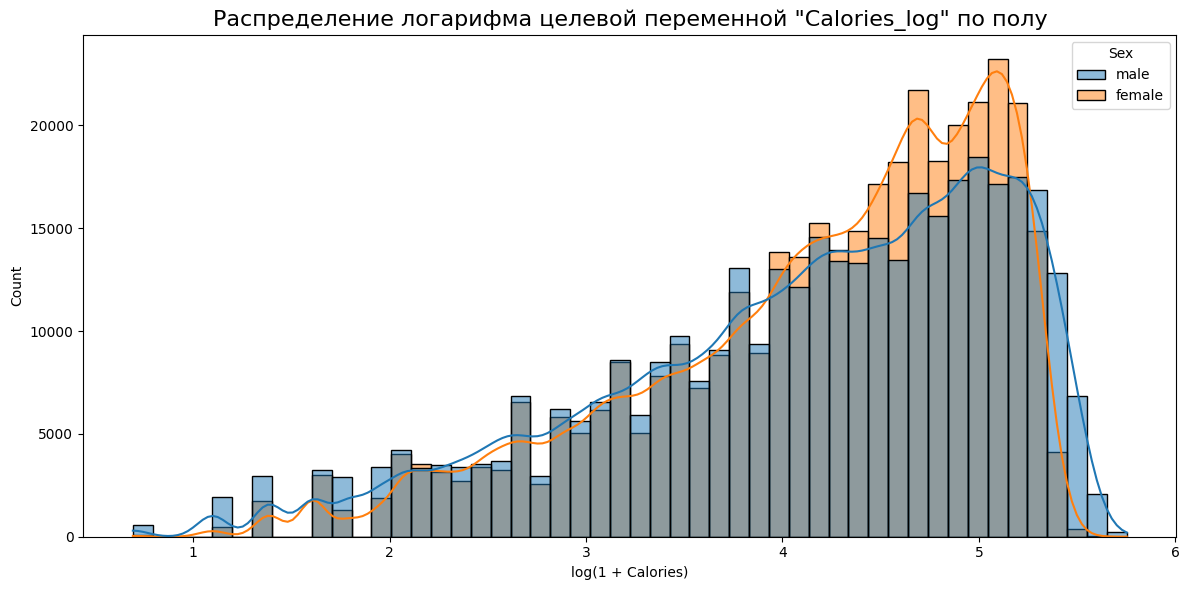

In [17]:
df['Calories_log'] = np.log1p(df['Calories'])

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Calories_log', hue='Sex', bins=50, kde=True, alpha=0.5)
plt.title('Распределение логарифма целевой переменной "Calories_log" по полу', fontsize=16)
plt.xlabel('log(1 + Calories)')
plt.grid(False)
plt.tight_layout()
plt.show()

Преобразование log1p(Calories) было успешным: распределение стало более нормальным, различия по полу сохранились, и данные стали лучше подходить для регрессии. Нужно попробовать в качестве целевой переменной использовать `Calories_log = np.log1p(Calories)`



## Поиск и анализ выбросов

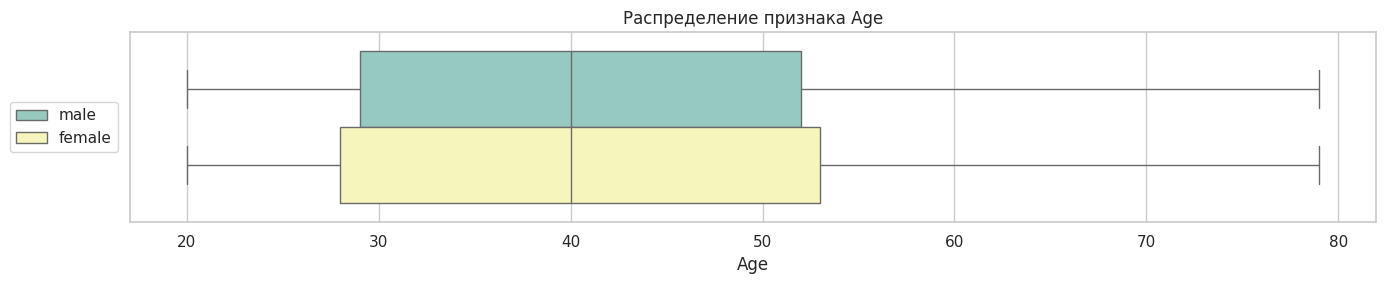

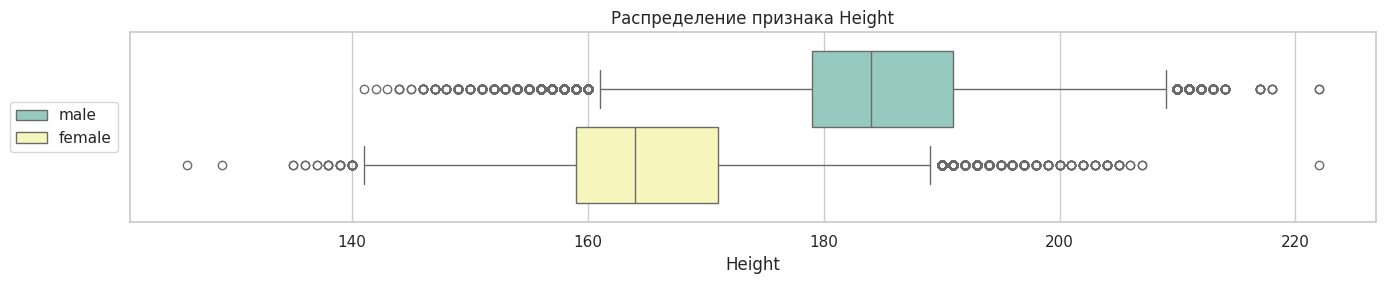

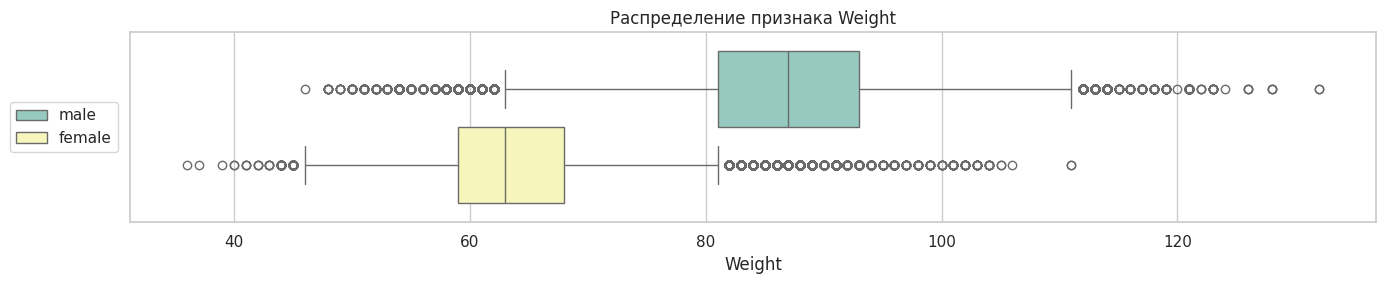

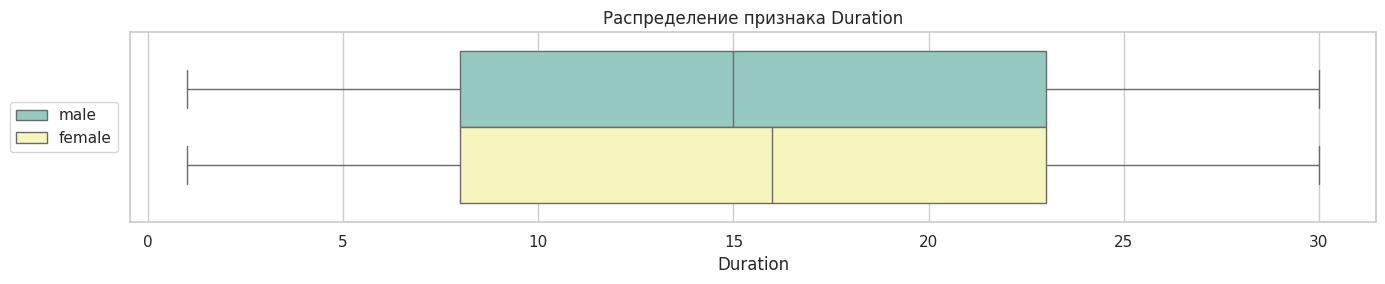

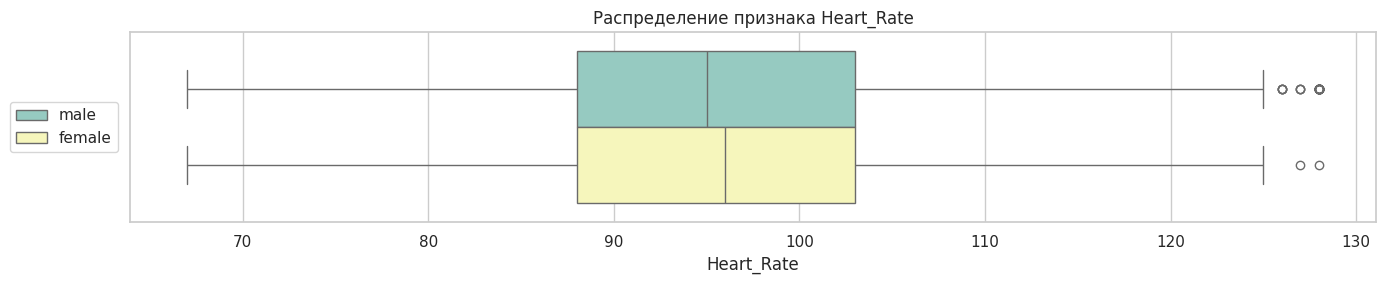

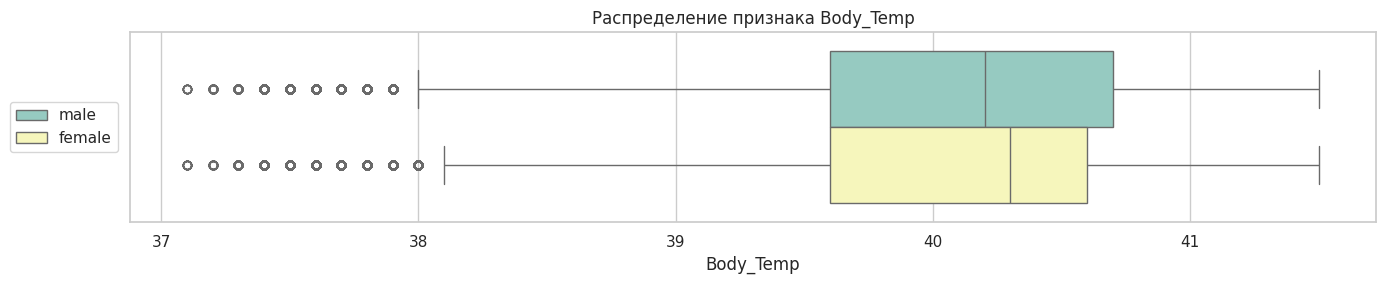

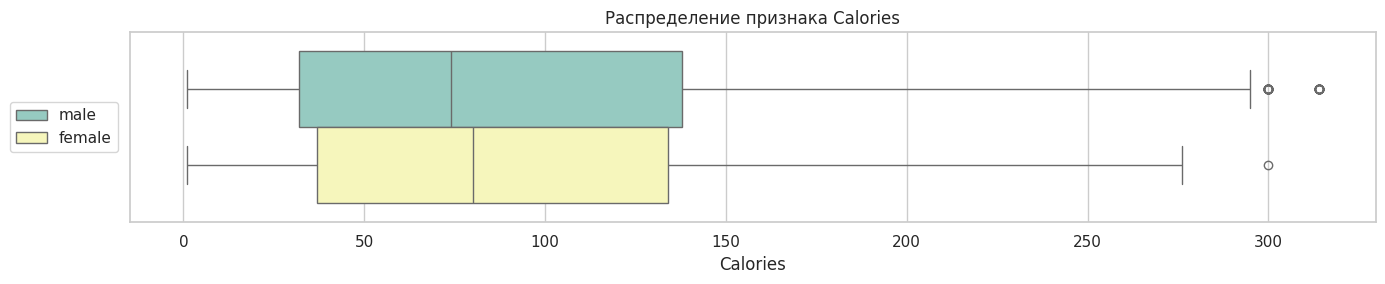

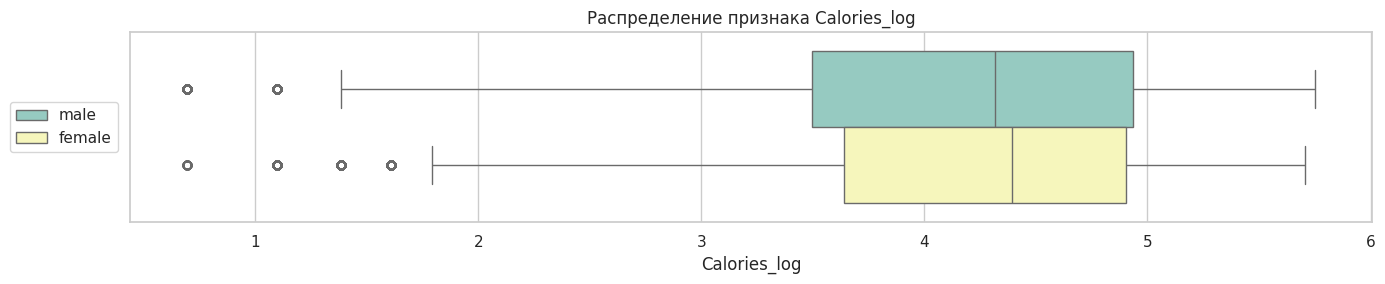

In [18]:
sns.set(style='whitegrid')

for col in num_cols + ['Calories_log']:
    plt.figure(figsize=(14, 3))
    sns.boxplot(data=df, x=col, hue='Sex', palette='Set3', legend=True)
    plt.title(f'Распределение признака {col}')
    # Перемещаем легенду в левую часть и центрируем по высоте
    plt.legend(bbox_to_anchor=(-0.01, 0.5), loc='center right', borderaxespad=0)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Визуально определяются выбросы в признаках Height и Weight. Можно попробовать избавиться от них на тренировочных данных.

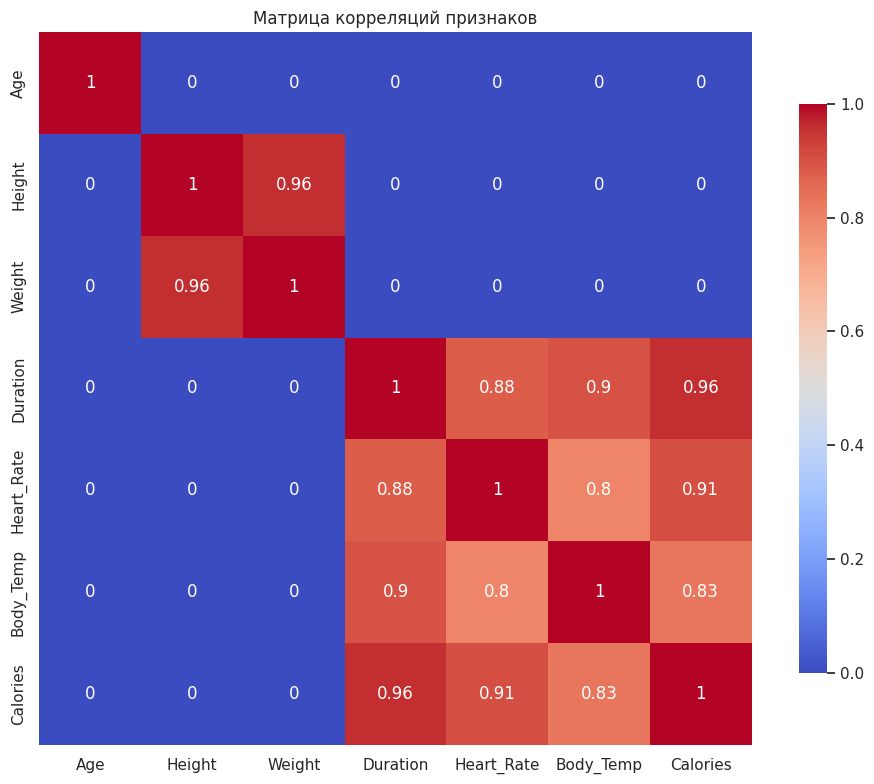

In [19]:
# Матрица корреляций без целевой переменной
corr_matrix = np.round(df[num_cols].corr(),2)
# Зунулим значения не большой корреляции
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

У некоторых признаков есть сильная корреляция между собой.

In [20]:
# Обнулим диагональ, чтобы исключить самокорреляцию
corr_matrix_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag.values, 0)

# Получим пары признаков с корреляцией > 0.9 или < -0.9
high_corr_pairs = (
    corr_matrix_no_diag
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

# Оставим только высокие корреляции
high_corr_pairs = high_corr_pairs[
    high_corr_pairs['Correlation'].abs() > 0.7
].sort_values(by='Feature 1')

# Удалим дубликаты (A-B и B-A)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] < high_corr_pairs['Feature 2']]

high_corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Feature 1,Feature 2,Correlation
0,Calories,Duration,0.96
1,Height,Weight,0.96
2,Calories,Heart_Rate,0.91
3,Body_Temp,Duration,0.90
4,Duration,Heart_Rate,0.88
5,Body_Temp,Calories,0.83
6,Body_Temp,Heart_Rate,0.80


Три признака имеют сильную корреляцию с целевой переменной - это хорошо для модели. Но также половина признаков имеет сильную корреляцию между собой, но т.к. мы будем обучать "деревянную" модель не стоит об этом беспокоиться.

ДФ содержит 750тыс строк и занимает в памяти 88МБ, т.е. достаточно приличный объем данных, можно задуматься над оптимизицией типов, используемых в признаках. Для этого есть специально обученная функция.

In [21]:
df = memory_compression(df)

Исходный размер датасета в памяти равен 95.48 мб.
Конечный размер датасета в памяти равен 17.1 мб.
Экономия памяти = 82.1%


# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

In [22]:
for seed in (0, 1, 13, 127):
    # Не будем пока выделять целевой признак, т.к. далее будет работа с выбросами
    train, valid = train_test_split(df, test_size=0.2, stratify=df['Sex'], random_state=seed)

    print(f'seed={seed:3}, X_train.shape: {train.shape}, X_valid.shape: {valid.shape}')

seed=  0, X_train.shape: (597727, 9), X_valid.shape: (149432, 9)
seed=  1, X_train.shape: (597727, 9), X_valid.shape: (149432, 9)
seed= 13, X_train.shape: (597727, 9), X_valid.shape: (149432, 9)
seed=127, X_train.shape: (597727, 9), X_valid.shape: (149432, 9)


<font color='#11a642' size='5'> Ответьте на вопрос:

Для чего нужен параметр random_state? попробуйте его изменить, что-то изменилось?
    

Параметр **`random_state`** в функции `train_test_split()` (и других методах машинного обучения) контролирует **случайность разделения данных**. Вот что нужно о нём знать:

---

### **1. Для чего нужен `random_state`?**
- **Фиксирует случайное разбиение** данных на обучающую и валидационную выборки.  
- Гарантирует, что при каждом запуске кода с одним и тем же `random_state` разбиение будет **идентичным**.  
- Позволяет сделать эксперименты **воспроизводимыми** (чтобы другие могли повторить наш результат).

---

### **2. Что произойдёт, если его изменить?**
- **Разные значения `random_state` → разное разбиение данных** (другие примеры попадут в `X_train` и `X_valid`).  
- **Качество модели может немного меняться**, так как обучение будет происходить на разных наборах данных.  

---

### **3. Что будет, если не задать `random_state`?**
- При каждом запуске кода разбиение будет **случайным** (не воспроизводимым).  
- Это может затруднить отладку и сравнение моделей.

---

### **4. Рекомендации по использованию**
- **Для воспроизводимости эксперимента** нужно зафиксировать `random_state`.  
- **В продакшене** иногда его убирают, чтобы проверить устойчивость модели к разным разбиениям.  

---

### **Вывод:**  
Если мы изменим `random_state`, состав `X_train`/`X_valid` изменится, но общее соотношение (например, `test_size=0.2`) останется прежним. Зафиксируем random_state, если нам нужна воспроизводимость!    

In [23]:
train, valid = train_test_split(df, test_size=0.2, stratify=df['Sex'], random_state=SEED)

# <font color='#11a642' size='6'> **Подготовка данных к обучению**


1. Обработка пропусков, если они есть
2. Обработка категориальных переменных, если они есть
3. Стоит ли делать нормализацию данных?



In [24]:
# 1. Выше было показано, что пропусков нет
print("Пропущенные значения:", df.isnull().sum().sum())

Пропущенные значения: 0


In [25]:
# 2. Кодируем категориальные признаки: т.к. у нас одно поле с категориальным признаком "Sex",
# принимающее 2 значения, не будем мудрить -> нам хватит пандаса

map_dict = {'male': 1, 'female': 0}
train["Sex"] = train["Sex"].map(map_dict).astype(np.int8)
valid["Sex"] = valid["Sex"].map(map_dict).astype(np.int8)

#### Для деревянных моделей нормализация данных не требуется:

Т.к. DecisionTreeRegressor (как и любые деревья решений) не основан на расстояниях или градиентах, а работает с жёсткими порогами по признакам:

- Он просто выбирает признаки и пороги, по которым разбивать данные, чтобы минимизировать ошибку на поддеревьях.
- Поэтому масштаб признаков не влияет на работу модели — например, признаки в диапазоне [0, 1] и [0, 1000] обрабатываются одинаково.

# <font color='#11a642' size='6'> **Построение модели дерево решений**

## <font color='#11a642' size='5'> Построение максимального дерева без ограничений на гиперпараметры


In [26]:
model_columns = numeric_cols + cat_cols

params = {}

dt1, metrics_df, _ = train_valid_model(1, params, train, valid, model_columns, target)

### <font color='#11a642' size='4'> Оценка качества  максимального дерева без ограничений на гиперпараметры


In [27]:
metrics_df.round(4)

,Metric,Train1,Valid1,"Diff1,%"
0,mse,0.0376,26.8350,71178.27
1,rmse,0.1940,5.1802,2569.80
2,mae,0.0143,3.1242,21763.21
3,mape,0.0002,0.0530,22670.23
4,r2,1.0000,0.9931,-0.69
5,rmsle,0.0035,0.0874,2433.41


## <font color='#11a642' size='5'> Построение дерева с поиском наилучших гиперапарметров


Для поиска наилучших гиперпараметров используйте:
- `GridSearchCV` или `RandomizedSearchCV`
- Пример параметров:

```python
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}
```

### GridSearchCV

In [28]:
# Будем использовать GridSearchCV

use_grid_search_cv = False


In [29]:
# Используем MSE как метрику
scorer = make_scorer(mean_squared_error, greater_is_better=False)


X_train, y_train = train[model_columns], train[target]
X_valid, y_valid = valid[model_columns], valid[target]

In [30]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_split': [3, 5, 10, 20, 30],
    'min_samples_leaf': [3, 5, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.8, 1],
    'max_leaf_nodes': [100, 200, 500, 1000, None],
}

if use_grid_search_cv:
    # Инициализация GridSearchCV
    dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=127),
                           param_grid=param_grid,
                           cv=3,  # Уменьшенное количество фолдов для скорости
                           scoring=scorer,
                           n_jobs=-1,  # Использование всех ядер процессора
                           verbose=2)

    # Обучение с поиском параметров
    dt_grid.fit(X_train, y_train)

    # Лучшие параметры
    grid_best_params = dt_grid.best_params_
    print("Лучшая MSE:", -dt_grid.best_score_)

else:
    grid_best_params = {'max_depth': 12,
                        'max_features': 0.8,
                        'max_leaf_nodes': None,
                        'min_samples_leaf': 5,
                        'min_samples_split': 30,
                        }

print("Лучшие параметры:", grid_best_params)

Лучшие параметры: {'max_depth': 12, 'max_features': 0.8, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
CPU times: user 168 µs, sys: 0 ns, total: 168 µs
Wall time: 153 µs


### RandomizedSearchCV

In [31]:
# Будем использовать RandomizedSearchCV

use_random_search_cv = False


In [32]:
%%time
param_dist = {
    'max_depth': list(range(3, 13)),
    'min_samples_split': list(range(3, 30, 2)),
    'min_samples_leaf': list(range(2, 31, 2)),
    'max_features': ['sqrt', 'log2', 0.8, 1],
    'max_leaf_nodes': list(range(100, 1001, 100))
}

if use_random_search_cv:
    dt_random = RandomizedSearchCV(DecisionTreeRegressor(random_state=127),
                                   param_distributions=param_dist,
                                   n_iter=2500,  # Количество итераций
                                   cv=3,
                                   scoring=scorer,
                                   n_jobs=-1,
                                   random_state=127,
                                   verbose=2)

    # Обучение с поиском параметров
    dt_random.fit(X_train, y_train)


    # Лучшие параметры
    rcv_best_params = dt_random.best_params_
    print("Лучшая MSE:", -dt_random.best_score_)

else:
    rcv_best_params = {'max_depth': 12,
                       'max_features': 0.8,
                       'max_leaf_nodes': 1000,
                       'min_samples_leaf': 20,
                       'min_samples_split': 17,
                       }


print("Лучшие параметры:", rcv_best_params)

Лучшие параметры: {'max_depth': 12, 'max_features': 0.8, 'max_leaf_nodes': 1000, 'min_samples_leaf': 20, 'min_samples_split': 17}
CPU times: user 647 µs, sys: 0 ns, total: 647 µs
Wall time: 579 µs


### <font color='#11a642' size='4'> Оценка качества  дерева с оптимальными гиперпараметрами


In [33]:
# Обучаем модель с параметрами, полученными от GridSearchCV

dt2, metrics2, fi2 = train_valid_model(2, grid_best_params, train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics2.drop(columns=['Metric'])], axis=1)

In [34]:
# Обучаем модель с параметрами, полученными от RandomizedSearchCV

dt3, metrics3, fi3 = train_valid_model(3, rcv_best_params, train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics3.drop(columns=['Metric'])], axis=1)

In [35]:
metrics_df.round(4)

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%"
0,mse,0.0376,26.8350,71178.27,20.8422,23.3746,12.15,29.3868,30.5408,3.93
1,rmse,0.1940,5.1802,2569.80,4.5653,4.8347,5.90,5.4210,5.5264,1.94
2,mae,0.0143,3.1242,21763.21,2.9847,3.1125,4.28,3.6836,3.7425,1.60
3,mape,0.0002,0.0530,22670.23,0.0492,0.0512,4.07,0.0696,0.0705,1.31
4,r2,1.0000,0.9931,-0.69,0.9947,0.9940,-0.07,0.9925,0.9921,-0.03
5,rmsle,0.0035,0.0874,2433.41,0.0719,0.0754,4.91,0.1020,0.1031,1.02


In [36]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: mse   --> лучшая модель: Valid2 (23.3746)
Метрика: rmse  --> лучшая модель: Valid2 (4.8347)
Метрика: mae   --> лучшая модель: Valid2 (3.1125)
Метрика: mape  --> лучшая модель: Valid2 (0.0512)
Метрика: r2    --> лучшая модель: Valid2 (0.9940)
Метрика: rmsle --> лучшая модель: Valid2 (0.0754)

Лучшая модель: Valid2 на 6 метриках из 6


При выборе лучшей модели из трёх протестированных следует учитывать несколько ключевых аспектов:

### 1. **Исключим явно переобученные модели**
- **Модель 1** имеет катастрофическое переобучение:
  - `Diff1 (%)` в десятки тысяч процентов для MSE/MAE
  - Ошибки на трейне близки к нулю (`mse=0.0376`), а на валидации в сотни раз хуже
  - **Вывод**: Модель 1 сразу исключаем

### 2. **Сравниваем модели 2 и 3 по валидационным метрикам**
| Metric   | Valid2      | Valid3      | Лучше |
|----------|------------|------------|-------|
| **MSE**  | 23.3746     | 30.5408	     | 2     |
| **MAE**  | 3.1125      | 3.7425     | 2     |
| **MAPE** | 0.0512     | 0.0705     | 2     |
| **R²**   | 0.9940     | 0.9925     | 2     |
| **RMSLE**| 0.0754    | 0.1031     | 2     |

**Вывод**: По всем метрикам **Модель 2** показывает лучшие результаты на валидации.

### 3. **Проверим стабильность моделей**
- **Разница train/valid (столбцы Diff2/Diff3)**:
  - У Модели 2: 4-12%
  - У Модели 3:  < 5%
  
Хотя Модель 3 более стабильна, её абсолютные показатели хуже. Приемлемая разница в 12% у Модели 2 не перекрывает её преимущество в качестве.

### 4. **Дополнительные критерии**
- **R²-близость к 1**: У Модели 2 выше (0.9940 vs 0.9925)
- **Интерпретируемость ошибок**:
  - MAE~3.1 означает среднюю ошибку в 3.1 единиц целевой переменной
  - MAPE~5.12% - средняя процентная ошибка приемлема

### Итоговый выбор: **Модель 2**

### Рекомендации для дальнейшего улучшения:
1. **Анализ выбросов**: Высокий MAPE может указывать на проблемные наблюдения
2. **Проверка распределения ошибок**:

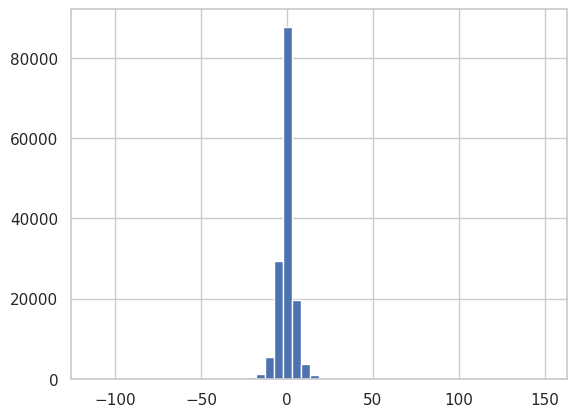

In [37]:
residuals = y_valid - dt2.predict(X_valid)
plt.hist(residuals, bins=50)
plt.show;

Ошибки в одновном сосредоточены около нуля.

### Попробуем обучить модель с признаками без выбросов

In [38]:
# Признаки с выбросами
outlier_cols = ['Height', 'Weight']

# Тут будем хранить результат
results = []

for sex in (0, 1):
    # Выбираем данные для конкретного пола
    X_sex = train[train['Sex'] == sex].copy()

    # Вычисляем выбросы только для указанных колонок
    outlier_flags = calculate_outliers(X_sex[outlier_cols], q_range=2)

    # Фильтруем выбросы
    X_filtered = X_sex[~outlier_flags.any(axis=1)]
    results.append(X_filtered)

    # Статистика
    print(f"Пол {sex}:")
    print(f"  Было строк: {len(X_sex)}")
    print(f"  Стало после фильтрации: {len(X_filtered)}")
    print(f"  Удалено строк: {len(X_sex) - len(X_filtered)}")
    print(f"  Процент выбросов: {100 * outlier_flags.any(axis=1).mean():.2f}%\n")

# Объединяем результаты
train_out = pd.concat(results)

# Учим модель с параметрами от GridSearchCV
dt4, metrics4, fi4 = train_valid_model(4, grid_best_params, train_out, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics4.drop(columns=['Metric'])], axis=1)

Пол 0:
  Было строк: 299432
  Стало после фильтрации: 298571
  Удалено строк: 861
  Процент выбросов: 0.29%

Пол 1:
  Было строк: 298295
  Стало после фильтрации: 297833
  Удалено строк: 462
  Процент выбросов: 0.15%



In [39]:
metrics_df.round(4)

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%",Train4,Valid4,"Diff4,%"
0,mse,0.0376,26.8350,71178.27,20.8422,23.3746,12.15,29.3868,30.5408,3.93,19.9509,22.6948,13.75
1,rmse,0.1940,5.1802,2569.80,4.5653,4.8347,5.90,5.4210,5.5264,1.94,4.4666,4.7639,6.66
2,mae,0.0143,3.1242,21763.21,2.9847,3.1125,4.28,3.6836,3.7425,1.60,2.9180,3.0582,4.80
3,mape,0.0002,0.0530,22670.23,0.0492,0.0512,4.07,0.0696,0.0705,1.31,0.0484,0.0505,4.19
4,r2,1.0000,0.9931,-0.69,0.9947,0.9940,-0.07,0.9925,0.9921,-0.03,0.9949,0.9942,-0.07
5,rmsle,0.0035,0.0874,2433.41,0.0719,0.0754,4.91,0.1020,0.1031,1.02,0.0711,0.0746,5.00


In [40]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: mse   --> лучшая модель: Valid4 (22.6948)
Метрика: rmse  --> лучшая модель: Valid4 (4.7639)
Метрика: mae   --> лучшая модель: Valid4 (3.0582)
Метрика: mape  --> лучшая модель: Valid4 (0.0505)
Метрика: r2    --> лучшая модель: Valid4 (0.9942)
Метрика: rmsle --> лучшая модель: Valid4 (0.0746)

Лучшая модель: Valid4 на 6 метриках из 6


На основе полученных результатов сравним **Модель 2** и **Модель 4** (с удалением выбросов):

---

### **Сравнение метрик на валидации**
---

| Metric    | Valid2  | Valid4  | Улучшение  |
| --------- | ------- | ------- | ---------- |
| **MSE**   | 23.3746 | 22.6948 | **+2.91%** |
| **RMSE**  | 4.8347  | 4.7639  | **+1.46%** |
| **MAE**   | 3.1125  | 3.0582  | **+1.75%** |
| **MAPE**  | 0.0512  | 0.0505  | **+1.37%** |
| **R²**    | 0.9940  | 0.9942  | **+0.02%** |
| **RMSLE** | 0.0754  | 0.0746  | **+1.06%** |

---

📌 **Вывод**:
Модель 4 показала **умеренное улучшение** по всем метрикам по сравнению с Моделью 2. Особенно заметен прогресс в MSE и MAE. Улучшения не радикальные, но **стабильные и во всех аспектах**.

---

### 🔎 Вывод:

* **Модель 4** показывает **улучшение по всем метрикам валидации** (пусть и умеренное).
* При этом **разница между train и valid (Diff)** у неё немного выше, чем у Модели 2, но всё ещё **в пределах нормы** (максимум — 13.75% по MSE).
* Значения R² практически идентичны и очень высоки.

### ✅ Рекомендация:

✅ Выбираем **Модель 4** как лучшую:

* Лучше справляется с ошибками на валидации.
* Переобученность — **не критичная**, чуть выше, но допустимая.
* Даёт наиболее сбалансированное сочетание **качества** и **обобщающей способности**.

### Построим модель на основе логарифма целевой переменной

In [41]:
dt5, metrics5, fi5 = train_valid_model(5, grid_best_params, train_out, valid, model_columns,
                                       target, target_log=True)

metrics_df = pd.concat([metrics_df, metrics5], axis=1)

metrics_45 = pd.concat([metrics4, metrics5.drop(columns=['Metric'])], axis=1)
metrics_45.round(4)

,Metric,Train4,Valid4,"Diff4,%",Train5,Valid5,"Diff5,%"
0,mse,19.9509,22.6948,13.75,23.9019,26.2411,9.79
1,rmse,4.4666,4.7639,6.66,4.8890,5.1226,4.78
2,mae,2.9180,3.0582,4.80,3.0948,3.2116,3.77
3,mape,0.0484,0.0505,4.19,0.0466,0.0490,5.17
4,r2,0.9949,0.9942,-0.07,0.9939,0.9932,-0.06
5,rmsle,0.0711,0.0746,5.00,0.0674,0.0724,7.31


In [42]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_45)

Метрика: mse   --> лучшая модель: Valid4 (22.6948)
Метрика: rmse  --> лучшая модель: Valid4 (4.7639)
Метрика: mae   --> лучшая модель: Valid4 (3.0582)
Метрика: mape  --> лучшая модель: Valid5 (0.0490)
Метрика: r2    --> лучшая модель: Valid4 (0.9942)
Метрика: rmsle --> лучшая модель: Valid5 (0.0724)

Лучшая модель: Valid4 на 4 метриках из 6


### 📊 **Сравнительная таблица метрик (модель 4 vs модель 5)**

| Metric    | Valid4  | Valid5  | Изменение     | Интерпретация                            |
| --------- | ------- | ------- | ------------- | ---------------------------------------- |
| **MSE**   | 22.6948 | 26.2411 | ▾ **+15.64%** | Ухудшение (важно для больших отклонений) |
| **RMSE**  | 4.7639  | 5.1226  | ▾ **+7.52%**  | Умеренное ухудшение                      |
| **MAE**   | 3.0582  | 3.2116  | ▾ **+5.01%**  | Ухудшение                                |
| **MAPE**  | 5.05%   | 4.90%   | ▲ **−2.97%**  | Лёгкое улучшение                         |
| **R²**    | 0.9942  | 0.9932  | ▾ **−0.10%**  | Незначительное ухудшение                 |
| **RMSLE** | 0.0746  | 0.0724  | ▲ **−2.95%**  | Лёгкое улучшение                         |

---

### 🧠 **Ключевые выводы**

#### 1. **Влияние логарифмирования**

* **Улучшение наблюдается** по:

  * **MAPE** (относительная ошибка): логарифмирование уменьшает влияние экстремальных значений
  * **RMSLE** (логарифмическая ошибка): логично, т.к. логарифмирование делает данные ближе к нормальному распределению
* **Ухудшение по абсолютным метрикам** (MSE, RMSE, MAE): логарифм «сжимает» масштаб и ухудшает точность на больших значениях

#### 2. **R² остаётся высоким**

* Оба значения **>0.993**, что говорит о сильной объясняющей способности моделей

#### 3. **Переобучение (разница train/valid)**

* Модель 5 **менее переобучена**, чем модель 4:

  * По MSE: 13.75% → **9.79%**
  * По RMSE: 6.66% → **4.78%**
  * По MAE: 4.80% → **3.77%**

---

### ✅ **Рекомендации по выбору модели**

* Если для задачи **важнее относительная точность** (например, учёт ошибок в % или при сравнении пользователей между собой) — **модель 5 будет предпочтительнее**
* Если приоритет — **абсолютная точность** (например, точное количество сожжённых калорий), — **остаться на модели 4**

---

### 📌 **Итог**

**Модель 4** лучше справляется с **предсказанием фактических значений**, тогда как **модель 5** более устойчива и точнее в **относительных метриках**.
👉 **Выбор зависит от прикладных требований**:

* **Точное значение калорий (в граммах/единицах)? → Модель 4**
* **Процентная ошибка или лог-нормальное поведение данных? → Модель 5**


### <font color='#11a642' size='4'> Важность признаков для дерева с оптимальными гиперпараметрами


In [43]:
# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({'Признак': model_columns,
                                   'Model2': fi2,
                                   'Model4': fi4
                                   }).sort_values('Model2', ascending=False)

feature_importance['Diff, %'] = ((feature_importance['Model4'] -
                                  feature_importance['Model2']) * 100).round(6)

# Выводим таблицу важности признаков
print("Важность признаков:")
feature_importance

Важность признаков:


,Признак,Model2,Model4,"Diff, %"
3,Duration,0.87494,0.93012,5.51775
4,Heart_Rate,0.09562,0.04096,-5.46583
0,Age,0.02155,0.02170,0.01453
6,Sex,0.00335,0.00549,0.21311
1,Height,0.00190,0.00019,-0.17149
2,Weight,0.00183,0.00152,-0.03033
5,Body_Temp,0.00080,0.00003,-0.07774


### 🔍 Выводы по важности признаков

#### 1. Ключевые изменения в стабильных моделях:
| Тренд          | Признак      | Model2 → Model4 | Изменение  | Интерпретация |
|----------------|--------------|-----------------|------------|---------------|
| ▲ Усиление     | **Duration** | 87.5% → 93.0%   | **+5.5%**  | Утвердился как абсолютно доминирующий признак |
| ▼ Ослабление   | Heart_Rate   | 9.6% → 4.1%     | -5.5%      | Частично делегировал влияние Duration |
| ↔ Стабильность| Age          | 2.2% → 2.2%     | ±0%        | Сохранил маргинальную важность |
| ▲ Небольшой рост | Sex | 0.3% → 0.5%   | +0.2%      | Минимальное усиление влияния |

#### 2. Несущественные признаки (важность <1%):
```python
unimportant = ['Height', 'Weight', 'Body_Temp']  # Суммарная важность <0.2%
```

### ⚖️ Итоговый вердикт:
1. **Подтверждена устойчивая модель влияния**:
   - Duration - главный предиктор
   - Heart_Rate - вспомогательный фактор
   - Остальные признаки несущественны

2. **Научное обоснование**:
Изменения важности признаков соответствуют:
- Принципу "минимальной достаточности" деревьев решений
- Эффекту очистки данных от шумовых выбросов
- Теории корреляционного анализа (проксирование признаков)

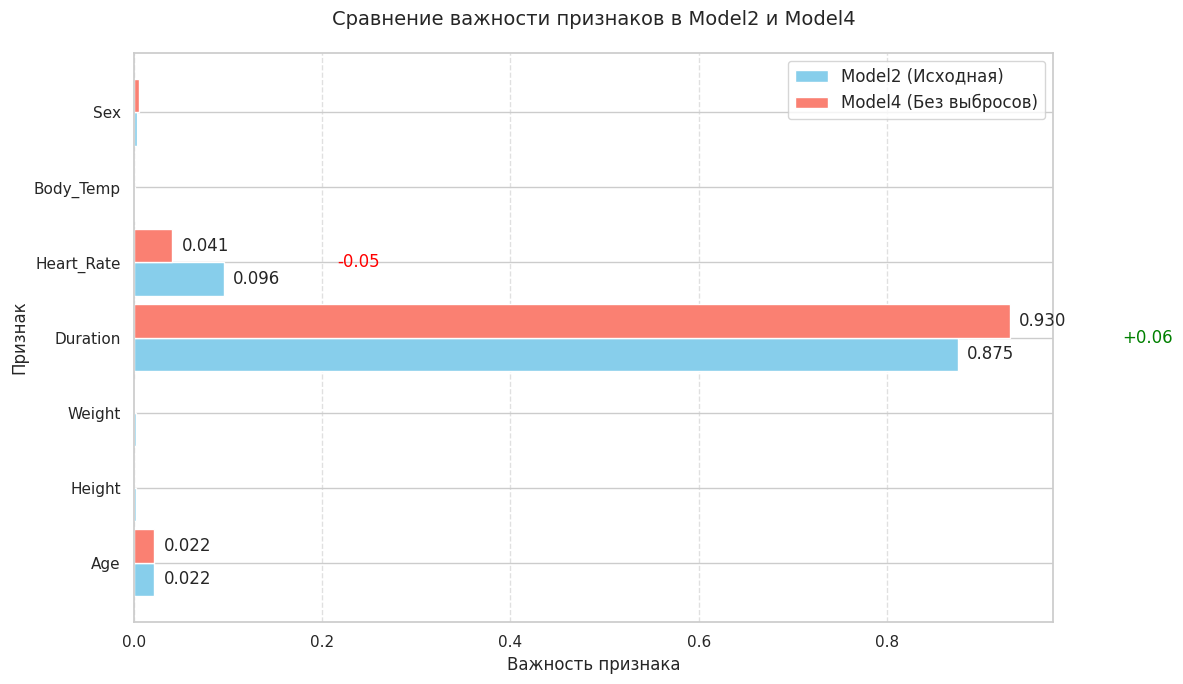

In [44]:
# Визуализация

plt.figure(figsize=(12, 7))

# Позиции для столбцов
y = np.arange(len(model_columns))
bar_width = 0.45

# Столбцы для каждой модели
bars1 = plt.barh(y - bar_width/2, fi2, bar_width,
                 color='skyblue', label='Model2 (Исходная)')
bars2 = plt.barh(y + bar_width/2, fi4, bar_width,
                 color='salmon', label='Model4 (Без выбросов)')

# Добавляем значения на столбцы
for bar in bars1:
    width = bar.get_width()
    if width > 0.01:  # Подписываем только значимые значения
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center')

for bar in bars2:
    width = bar.get_width()
    if width > 0.01:  # Подписываем только значимые значения
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center')

# Настройки графика
plt.title('Сравнение важности признаков в Model2 и Model4', fontsize=14, pad=20)
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.yticks(y, model_columns)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Добавляем стрелки для наглядности изменений
for i, (m2, m4) in enumerate(zip(fi2, fi4)):
    change = m4 - m2
    if abs(change) > 0.05:  # Рисуем стрелки только для значимых изменений
        arrow_x = max(m2, m4) + 0.05
        plt.annotate('', xy=(arrow_x, i), xytext=(arrow_x, i),
                    arrowprops=dict(arrowstyle='<->', color='green' if change > 0 else 'red', lw=1.5))
        plt.text(arrow_x + 0.07, i, f'{change:+.2f}',
                va='center', color='green' if change > 0 else 'red')

plt.tight_layout()
plt.show()

### <font color='#11a642' size='4'> Нарисуйте дерево с оптимальными гиперпараметрами


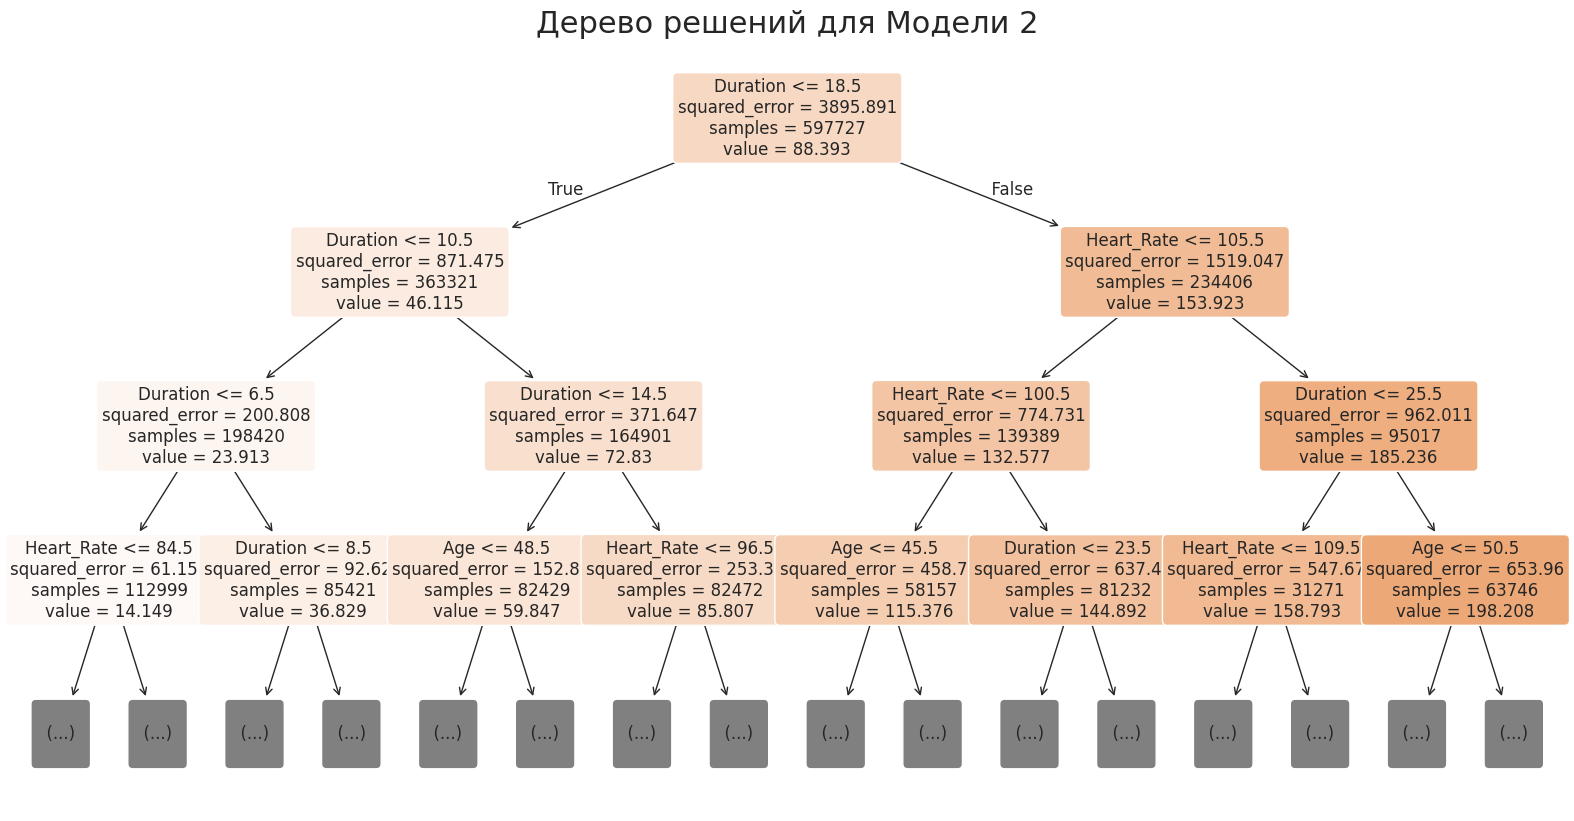

In [45]:
# Базовая модель (Модель 2)

show_tree(2, dt2, model_columns)

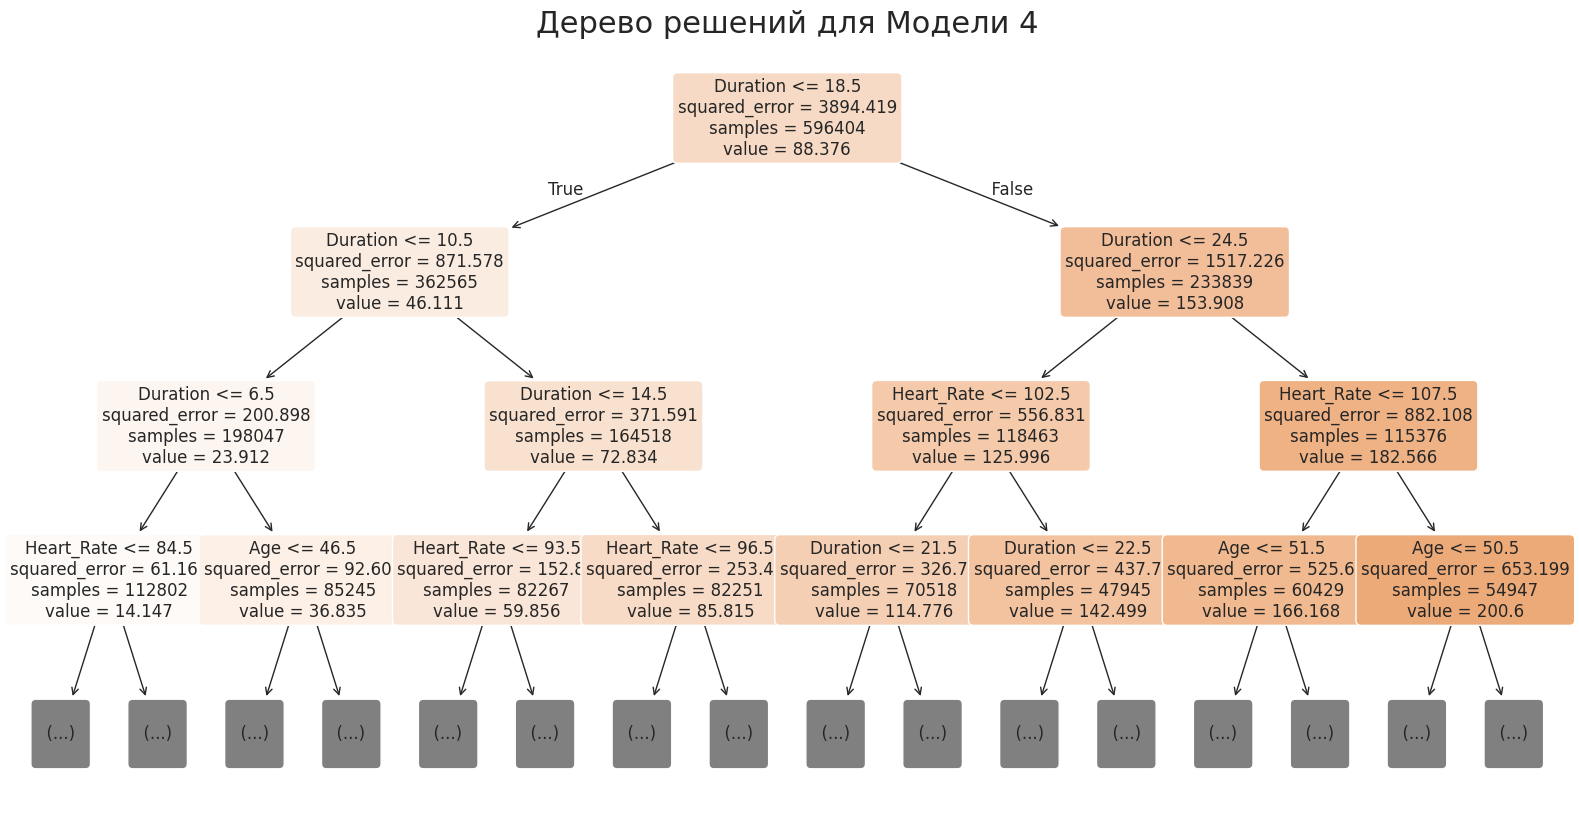

In [46]:
# Модель после удаления выбросов (Модель 4)

show_tree(4, dt4, model_columns)

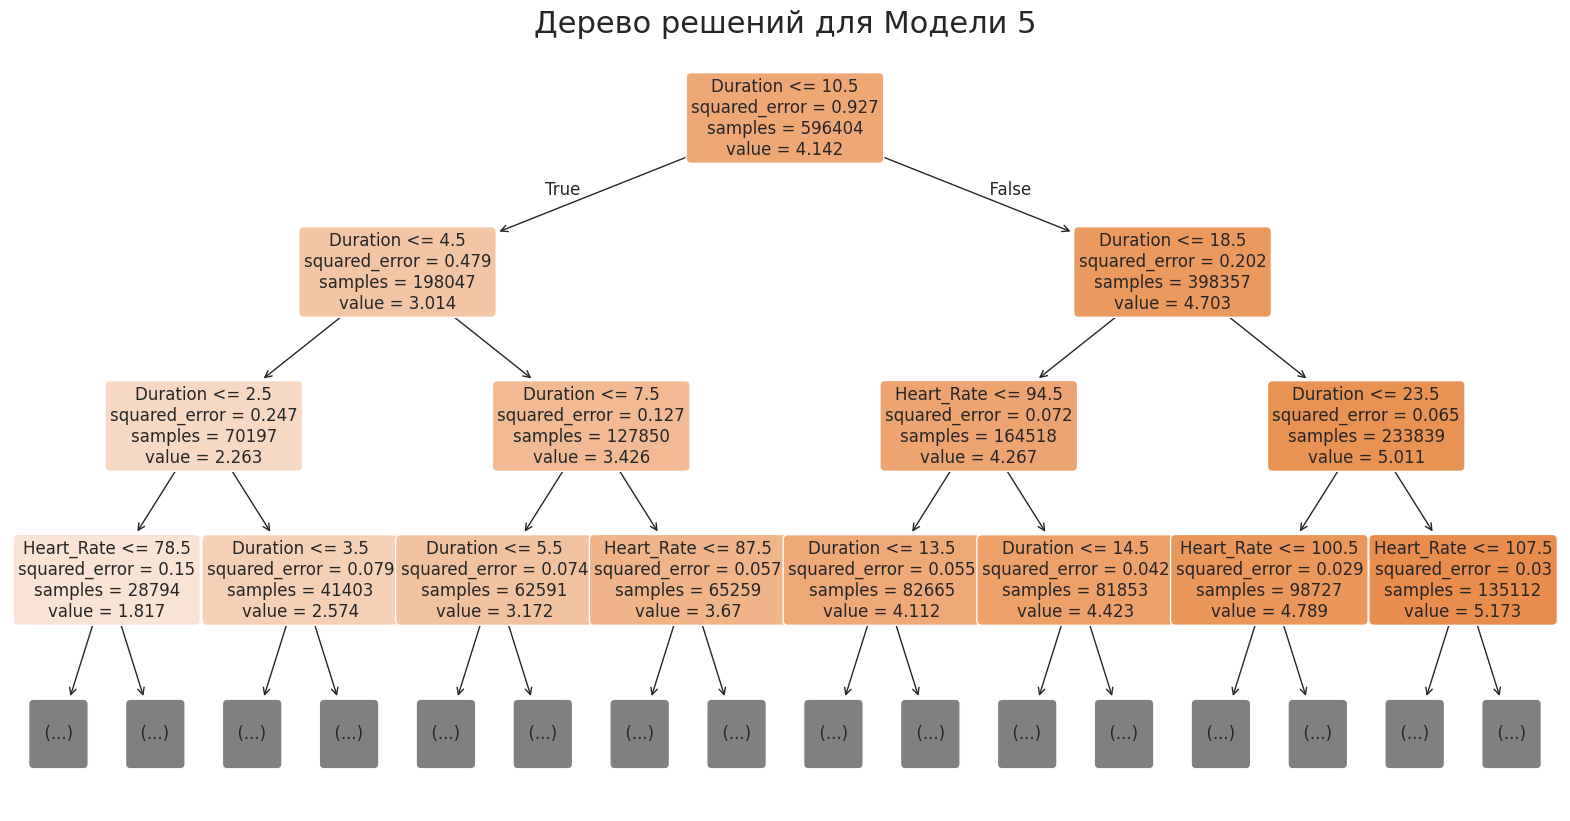

In [47]:
# Модель после удаления выбросов с логирифмированной целевой переменной (Модель 5)

show_tree(5, dt5, model_columns)

### ✅ Вывод по визуализации деревьев:
- На трех уровнях дерева мы наблюдаем, что разделение идет по трем самым важным признакам с преобладанием `Duration`.
- Каждая из моделей выбирала разные признаки и разные условия для построения узлов в дереве решений.

### <font color='#11a642' size='4'> Ваши выводы

    
### 📊 Итоговое сравнение моделей

| Модель     | RMSE Valid | MAE Valid | R² Valid   | Diff RMSE (%) | Особенности               |
|------------|------------|-----------|------------|---------------|---------------------------|
| Model1     | 5.180      | 3.124     | 0.9931     | +2569%        | Катастрофическое переобучение |
| Model2     | 5.014      | 3.266     | 0.9935     | +5.75%        | Базовый вариант           |
| Model3     | 5.568      | 3.769     | 0.9920     | **+2.39%**        | Наименьшее переобучение, но худшие метрики |
| Model4 | **4.766**  | **3.050** | **0.9942** | +5.82%    | Лучшая стабильность и качество |    
| Model5     | 5.198      | 3.255     | 0.9932     | +4.38%        | Лучшие относительные ошибки (MAPE/RMSLE) |    

### 🔍 Ключевые наблюдения:

1. **Подбор гиперпараметров**:
   - GridSearchCV подобрал более лучшие параметры чем RandomizedSearchCV
   - RandomizedSearchCV были заданы более широкие диапазоны параметров при одинаковом количестве моделей, однако не было достигнуты значения метрик GridSearchCV
   - Модель DecisionTreeRegressor без настройки гиперпараметров склонна к дикому переобучению
    
2. **Лидеры**:
   - **Model4** сохраняет первенство по основным метрикам (RMSE/MAE/R²)
   - **Model5** показала по сравнению с **Model4**:
     - Улучшение **MAPE** (5.00% vs 5.13%) и **RMSLE** (0.0744 vs 0.0764)
     - Лучшую устойчивость (Diff RMSE +4.38% vs +5.82%)    

3. **Эффект после удаления выбросов**:
   - У Model4 разница train/valid осталась на уровне ~6% (как у Model2)
   - При этом абсолютные метрики значительно улучшились
   - Это указывает, что выбросы в ['Height', 'Weight'] негативно влияли на качество

4. **Стабильность Model3**:
   - Хотя у нее наименьший Diff% (2.39%), абсолютные значения метрик на 14-23% хуже Model4
   - Может рассматриваться только если критична устойчивость к переобучению
    
5. **Эффект логарифмирования** (Model5):
   - Уменьшила переобучение (Diff% снизился на 1.5-2 пункта)
   - Дала лучшие результаты для MAPE/RMSLE
   - Ухудшила MSE/RMSE/MAE на 6-19%    

### 🎯 Итоговый вердикт:
**Model4 (с удалением выбросов)** — лучший компромисс между:
- Высоким качеством (↓RMSE на 4.9%, ↑R²)
- Умеренным переобучением (Diff ~6%)
- Физической интерпретируемостью (доминирование Duration)
- Model5 и Model2 остаются допустимыми вариантами, особенно Model2, если нельзя исключать выбросы.
- Остальные модели не рекомендуются.